<h1 align="center"> TP IoT - MS BGD 2016-2017</h1>
<h2><font color="#DF0174"> Géolocaliser des objets connectés à partir des antennes qui reçoivent leurs messages </font></h2>

In [1]:
# Les imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from geopy.distance import vincenty
import folium
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
import statsmodels.api as sm
from IPython.display import display
from numpy.linalg import inv
from sklearn import tree
from sklearn import neighbors
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import BaggingRegressor

<h1><font color="#DF0174"> I) Preliminary steps ...</font></h1>
<h2> 1. Loading data ...</h2>

In [2]:
df_mess_train = pd.read_csv('data/mess_train_list.csv')
df_mess_test = pd.read_csv('data/mess_test_list.csv')
pos_train = pd.read_csv('data/pos_train_list.csv')

<h2>2. Data overview ... </h2>

In [3]:
print(pos_train.head())
print()
for device_position in pos_train[:5].iterrows():
    print("Lat : {} - Long : {}".format(device_position[1]['lat'], device_position[1]['lng']))

         lat         lng
0  39.606690 -104.958490
1  39.606690 -104.958490
2  39.637741 -104.958554
3  39.730417 -104.968940
4  39.730417 -104.968940

Lat : 39.606689521599996 - Long : -104.958489931
Lat : 39.606689521599996 - Long : -104.958489931
Lat : 39.6377412341 - Long : -104.958554156
Lat : 39.7304174328 - Long : -104.96894015299999
Lat : 39.7304174328 - Long : -104.96894015299999


<h2> 3. Data visualization ... </h2>

In [4]:
MAX_RECORDS = 100

# 1 - Center the map around the first record location
map = folium.Map(location=[pos_train['lat'].ix[0],pos_train['lng'].ix[0]], zoom_start=12)

# 2  - Put the first devices location on the map
for device_position in pos_train[:MAX_RECORDS].iterrows():
    map.simple_marker(
        location = [device_position[1]['lat'], device_position[1]['lng']])

# 3  - Print the antenna locations on the map using orange dots
for antenna in df_mess_test[0:MAX_RECORDS].iterrows():
     map.circle_marker(location=[antenna[1]['bs_lat'] , antenna[1]['bs_lng']], radius=400,
                    popup='Base', line_color='#3186cc',
                    fill_color='orange')
    
display(map)

<h2> 4. Building the features matrix... </h2>

In [5]:
# On extrait toutes les bases qui ont reçu au moins un message dans la base de données de training et test
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), 
                      np.unique(df_mess_test['bsid'])) 
print('Nombre de bases ayant reçu au moins un message = ', listOfBs.size)

Nombre de bases ayant reçu au moins un message =  259


In [6]:
def feat_mat_const(df_mess_train, listOfBs):
    # group data by message (objid)
    df_mess_by_objid = df_mess_train.groupby(['objid'], as_index=False) 
    nb_mess = len(np.unique(df_mess_train['objid']))
    # feature matrix contains a row for each message, and a column for each antenna
    df_feat = pd.DataFrame(np.zeros((nb_mess, len(listOfBs))), columns = listOfBs) 
    idx = 0

    #Inserts 1 into every column correponsding to an antenna having received a given message
    for key, elmt in df_mess_by_objid:
        df_mess_by_objid.get_group(key)
        df_feat.loc[idx, df_mess_by_objid.get_group(key)['bsid']] = 1
        idx = idx + 1
    
    return df_feat

In [7]:
# This matrix will be used as our training set
df_feat = feat_mat_const(df_mess_train, listOfBs)

In [73]:
def feat_mat_constRSSI(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['objid'], as_index=False) # group data by message (objid)
    nb_mess = len(np.unique(df_mess_train['objid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx, df_mess_bs_group.get_group(key)['bsid']] = df_mess_bs_group.get_group(key)['rssi'].values
        idx = idx + 1
    
    return df_feat

In [9]:
df_feat_rssi = feat_mat_constRSSI(df_mess_train, listOfBs)

In [10]:
print(df_feat_rssi)

      879    911    921    944    980    1012   1086   1092   1120   1131   \
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0    0.0    0.0    0.0    0.0    0.0 -141.0    0.0    0.0    0.0   
5       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
11      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    

In [11]:
ind = df_feat_rssi[(df_feat_rssi[df_feat_rssi == 0].isnull().sum(axis=1)) > 2].index

pos_train_no_null = pos_train.ix[ind, :]
df_feat_rssi_no_null = df_feat_rssi[(df_feat_rssi[df_feat_rssi == 0].isnull().sum(axis=1)) > 2]

In [12]:
print(df_feat_rssi_no_null)

      879    911    921    944    980    1012   1086   1092   1120   1131   \
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0    0.0    0.0    0.0    0.0    0.0 -141.0    0.0    0.0    0.0   
5       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
16      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
18      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
19      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
20      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
21      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
22      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    

In [13]:
print("Value minimum de RSSI dans toute la matrice: %s" % df_feat_rssi_no_null.min().min())

df_feat_rssi_no_null[df_feat_rssi_no_null == 0] = -200

print("Value minimum de RSSI dans toute la matrice: %s" % df_feat_rssi_no_null.max().max())

Value minimum de RSSI dans toutes la matrice: -155.0
Value minimum de RSSI dans toutes la matrice: -69.0


In [14]:
# new_df =  df_mess_train.copy()
# Normalisation des colonnes rssi.
# new_df['rssi'] = np.exp(new_df['rssi'])
# new_df['rssi_norm']  = (new_df['rssi'] - new_df['rssi'].mean()) / (new_df['rssi'].max()  - new_df['rssi'].min())

# df_feat = feat_mat_constRSSI(new_df, listOfBs)

<h2> 5. Defining a loss function... </h2>

In [15]:
def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['objid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['objid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [16]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)

In [17]:
ground_truth_lat_not_null = ground_truth_lat[ind]
ground_truth_lng_not_null = ground_truth_lng[ind]

In [18]:
# Fonctions nécessaires à l'évaluation des résultats
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m, 0:2], vec_coord[m, 2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

# Calcul de la distance entre la vraie coordonnée et la coordonée estimée.
def eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    return err_vec

<h3> 5.1 Critère d'évaluation </h3>

In [19]:
def print_percentile_error(quantile=80):
    err = np.percentile(err_vec, quantile)
    listErr.append(err)
    print("In {}% of the cases, the error is less than {} km.".format(quantile,err/1000) )

In [20]:
listErr = []
df_erreur = pd.DataFrame()

<h1> <font color="#DF0174">II) Trying out various ML algorithms... <font></h1>

<h2> 1.  Nearest Neighbors Regression </h2>

In [21]:
from sklearn.neighbors import KNeighborsRegressor
X_train = np.array(df_feat_rssi_no_null);
# 15 plus proches voisins
# on choisit la distance comme critère de poid, avec comme métrique, la norme L1
clf_knn = neighbors.KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', p=2)
y_pred_lng = cross_val_predict(clf_knn, X_train, ground_truth_lng_not_null, cv=10)
y_pred_lat = cross_val_predict(clf_knn, X_train, ground_truth_lat_not_null, cv=10)
err_vec = eval_geoloc(ground_truth_lat_not_null , ground_truth_lng_not_null, y_pred_lat, y_pred_lng)
df_erreur['err_KNR'] = err_vec
print_percentile_error()
# clf_knn.fit(X_train, clf_knn)

In 80% of the cases, the error is less than 2.337937017575724 km.


<h2>2.  Bagging regressor </h2>

In [22]:
clf_bag = BaggingRegressor(base_estimator=tree.DecisionTreeRegressor(),
                           n_estimators=35,
                           bootstrap=True,
                           oob_score=True,
                           random_state=42)

In [23]:
clf_bag = BaggingRegressor(base_estimator=clf_knn,
                           n_estimators=35,
                           bootstrap=True,
                           oob_score=True,
                           random_state=42)

In [24]:
y_pred_lng = cross_val_predict(clf_bag, X_train, ground_truth_lng_not_null, cv=8, n_jobs=-1)
y_pred_lat = cross_val_predict(clf_bag, X_train, ground_truth_lat_not_null, cv=8, n_jobs=-1)
err_vec = eval_geoloc(ground_truth_lat_not_null , ground_truth_lng_not_null, y_pred_lat, y_pred_lng)
df_erreur['err_KNR'] = err_vec
print_percentile_error()
# clf_knn.fit(X_train, clf_knn)

In 80% of the cases, the error is less than 2.3777753191646984 km.


In [39]:
from sklearn.ensemble import ExtraTreesRegressor

X_train = np.array(df_feat);

# Build a forest and compute the feature importances
for n_est in np.arange(20, 51, 5):
    extra_trees = ExtraTreesRegressor(n_estimators=n_est, max_features='sqrt', max_depth=500)
    y_pred_lng = cross_val_predict(extra_trees, X_train, ground_truth_lng, cv=8, n_jobs=-1)
    y_pred_lat = cross_val_predict(extra_trees, X_train, ground_truth_lat, cv=8, n_jobs=-1)

    err_vec = eval_geoloc(ground_truth_lat, ground_truth_lng, y_pred_lat, y_pred_lng)
    # df_erreur['err_ExtraTrees_RSSI'] = err_vec
    err = np.percentile(err_vec, 80)
    listErr.append(err)
    print('Erreur à 80% en km = ', err / 1000)
    
print(listErr)

Erreur à 80% en km =  3.50654163266
Erreur à 80% en km =  3.45909933999
Erreur à 80% en km =  3.48783444906
Erreur à 80% en km =  3.44403211002
Erreur à 80% en km =  3.44189243934
Erreur à 80% en km =  3.43448749691
Erreur à 80% en km =  3.42031945984
[2337.937017575724, 2377.7753191646984, 3791.978111030432, 3703.8276384342939, 3692.1402772050201, 3654.9642695550037, 3665.3418725203519, 3662.4771154321097, 3685.5920452032642, 3714.6304178535574, 3459.0993399915169, 3459.0993399915169, 3459.0993399915169, 3459.0993399915169, 3459.0993399915169, 3459.0993399915169, 3459.0993399915169, 3506.5416326590557, 3459.0993399915169, 3487.8344490630489, 3444.032110021953, 3441.8924393353909, 3434.4874969071361, 3420.319459839342]


In [40]:
X_train = np.array(df_feat);
reg = linear_model.LinearRegression()

<h3> 1.1 Cross - Validation </h3>

In [41]:
y_pred_lng = cross_val_predict(reg, X_train, ground_truth_lng, cv=8, n_jobs=-1)
y_pred_lat = cross_val_predict(reg, X_train, ground_truth_lat, cv=8, n_jobs=-1)

### 1.2 Evaluation des résultats

In [50]:
err_vec = eval_geoloc(ground_truth_lat, ground_truth_lng, y_pred_lat, y_pred_lng)
print(np.percentile(err_vec, 80))

8483.29100053


### 1.3 Plot de la courbes des erreurs cumulées

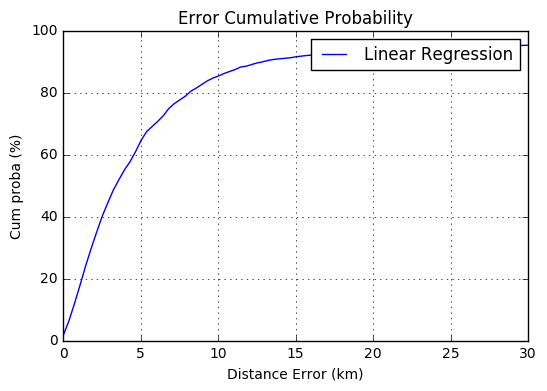

In [51]:
def plot_cumulated_errors(err_vec, algo, bins=50000):
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 
    plt.figure();
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
    plt.title('Error Cumulative Probability'); plt.legend( [algo])
    
plot_cumulated_errors(err_vec, "Linear Regression")
    

<h3> 1.4 Critère d'évaluation </h3>

In [52]:
def print_percentile_error(quantile=80):
    err = np.percentile(err_vec, quantile)
    listErr.append(err)
    print("In {}% of the cases, the error is less than {} km.".format(quantile,err/1000) )

print_percentile_error()

In 80% of the cases, the error is less than 8.483291000534633 km.


<h2> 2.  Nearest Neighbors Regression </h2>

In [54]:
from sklearn.neighbors import KNeighborsRegressor
X_train = np.array(df_feat_rssi);
# 15 plus proches voisins
# on choisit la distance comme critère de poid, avec comme métrique, la norme L1
clf_knn = neighbors.KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', p=1)
y_pred_lng = cross_val_predict(clf_knn, X_train, ground_truth_lng, cv=8, n_jobs=-1)
y_pred_lat = cross_val_predict(clf_knn, X_train, ground_truth_lat, cv=8, n_jobs=-1)
err_vec = eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)
# df_erreur['err_KNR'] = err_vec
print_percentile_error()
# clf_knn.fit(X_train, clf_knn)


In 80% of the cases, the error is less than 3.8588735630612985 km.


### 2.1 Cross -  Validation

In [55]:
def print_cv_perfs(clf):
    print("Best parameters set found on development set: ")
    print()
    print("{} with score : {}".format(clf.best_params_ , clf.best_score_))
    '''
    print()
    print("Grid scores on development set:")
    print()
    means_test = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    means_train = clf.cv_results_['mean_train_score']
    for mean_tst, mean_tr, std, params in zip(means_test,means_train, stds, clf.cv_results_['params']):
        print("%0.3f (train: %0.3f) (std +/-%0.03f) for %r"
              % (mean_tst, mean_tr, std * 2, params))
    print()
    '''

In [20]:
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_neighbors': np.arange(6, 8)}

# clf = GridSearchCV(clf_knn, param_grid=param_test1, scoring='accuracy', n_jobs=-1, cv=4)
# clf.fit(X_train, clf_knn)
# print_cv_perfs(clf)

In [56]:
y_pred_lng = cross_val_predict(clf_knn, X_train, ground_truth_lng, cv=8, n_jobs=-1)
y_pred_lat = cross_val_predict(clf_knn, X_train, ground_truth_lat, cv=8, n_jobs=-1)

### 2.2 Evaluation des résultats

In [57]:
err_vec = eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)
print_percentile_error()
# df_erreur['err_KNN'] = err_vec

In 80% of the cases, the error is less than 3.8588735630612985 km.


<h3> 2.3 Plot de la courbes des erreurs cumulées </h3>

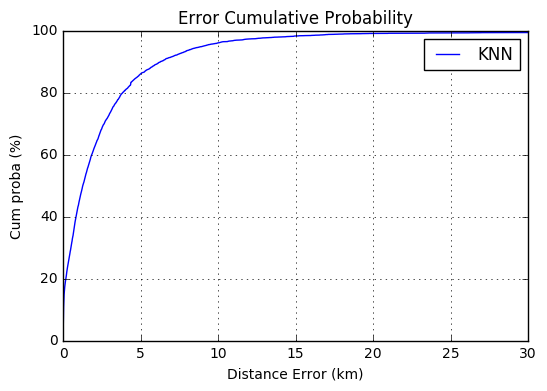

In [58]:
plot_cumulated_errors(err_vec, "KNN")

<h3> 2.4 Critère d'évaluation </h3>

In [59]:
print_percentile_error()

In 80% of the cases, the error is less than 3.8588735630612985 km.


<h2>3)  Bagging regressor </h2>

In [60]:
clf_bag = BaggingRegressor(base_estimator=tree.DecisionTreeRegressor(),
                           n_estimators=35,
                           bootstrap=True,
                           oob_score=True,
                           random_state=42)

<h3> 3.1 Cross - Validation </h3>

In [61]:
y_pred_lng = cross_val_predict(clf_bag, X_train, ground_truth_lng, cv=8, n_jobs=-1)
y_pred_lat = cross_val_predict(clf_bag, X_train, ground_truth_lat, cv=8, n_jobs=-1)

<h3> 3.2 Evaluation des résultats</h3>

In [63]:
err_vec = eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)
print_percentile_error()

In 80% of the cases, the error is less than 3.8533819673233847 km.


<h3> 3.3 Plot de la courbes des erreurs cumulées</h3>

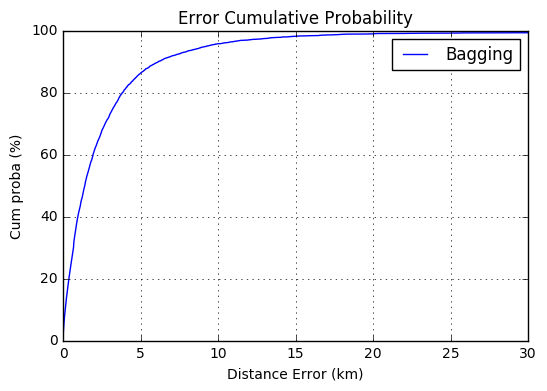

In [64]:
plot_cumulated_errors(err_vec, "Bagging")

### 3.4 Critère d'évaluation

In [65]:
print_percentile_error()

In 80% of the cases, the error is less than 3.8533819673233847 km.


# Prise en compte du RSSI 

* Nous intégrons dans la matrice des features les RSSI. Pour cela, tout d'abord nous normalisons la colonne des RSSI et nous refabriquons la matrice des features

## Construction de la matrice de "features" avec les RSSI

In [74]:
def feat_mat_constRSSI_norm(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['objid'], as_index=False) # group data by message (objid)
    nb_mess = len(np.unique(df_mess_train['objid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx, df_mess_bs_group.get_group(key)['bsid']] = df_mess_bs_group.get_group(key)['rssi_norm'].values
        idx = idx + 1
    
    return df_feat


In [67]:
new_df =  df_mess_train.copy()
#Normalisation des colonnes rssi.
new_df['rssi'] = np.exp(new_df['rssi'])
new_df['rssi_norm']  = (new_df['rssi'] - new_df['rssi'].mean()) / (new_df['rssi'].max()  - new_df['rssi'].min())

df_feat = feat_mat_constRSSI_norm(new_df, listOfBs)

## kNN en prenant compte les RSSI

In 80% of the cases, the error is less than 3.633722400584242 km.


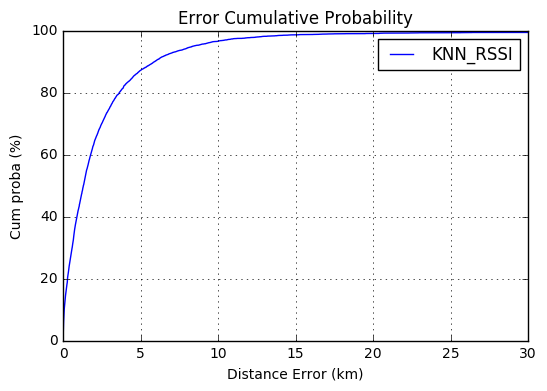

In [68]:
X_train = np.array(df_feat);
clf_RSSI = neighbors.KNeighborsRegressor(n_neighbors=7, weights='distance', algorithm='auto', p=1)
y_pred_lng = cross_val_predict(clf_RSSI, X_train, ground_truth_lng, cv=8, n_jobs=-1)
y_pred_lat = cross_val_predict(clf_RSSI, X_train, ground_truth_lat, cv=8, n_jobs=-1)

err_vec = eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)
print_percentile_error()
plot_cumulated_errors(err_vec, "KNN_RSSI")

### ExtraTrees en prenant compte les RSSI

In 80% of the cases, the error is less than 4.266702266690214 km.


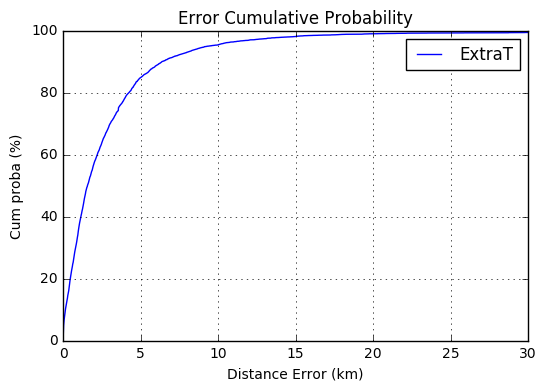

In [70]:
from sklearn.ensemble import ExtraTreesRegressor

# Build a forest and compute the feature importances
extra_trees = ExtraTreesRegressor()
X_train = np.array(df_feat);
y_pred_lng = cross_val_predict(extra_trees, X_train, ground_truth_lng, cv=8, n_jobs=-1)
y_pred_lat = cross_val_predict(extra_trees, X_train, ground_truth_lat, cv=8, n_jobs=-1)
err_vec = eval_geoloc(ground_truth_lat, ground_truth_lng, y_pred_lat, y_pred_lng)
print_percentile_error()
plot_cumulated_errors(err_vec, "ExtraT")

# Conclusions et Synthèse

*  La régression de Bagging Boosting basée sur des arbres de décision donne les meilleurs résultats.
*  L'ajout des RSSI dans la matrice de features n'amèliore pas les données.
   Au contraire les erreurs sont plus elevés. La mesure du RSSI est impactée par le phénomène de multipath, et donc
   cette mesure n'est pas très précise.



In [71]:
d = {'Erreur à 80% en km' : listErr}
df = pd.DataFrame(d)
df['Erreur à 80% en km'] = df['Erreur à 80% en km']/1000
df.rename(index={0: 'Linear Regression', 1: 'KNN', 2: 'Bagging Boosting', 3: 'kNN RSSI', 4: 'ExtraT RSSI'})

,Erreur à 80% en km
Linear Regression,2.337937
KNN,2.377775
Bagging Boosting,3.791978
kNN RSSI,3.703828
ExtraT RSSI,3.692140
5,3.654964
6,3.665342
7,3.662477
8,3.685592
9,3.714630


# Exports des résultats en CSV

In [76]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    X_train = np.array(df_feat);
    clf = neighbors.KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', p=2)

    clf.fit(X_train, ground_truth_lat);
    y_pred_lat = clf.predict(df_test) 

    clf.fit(X_train, ground_truth_lng);
    y_pred_lng = clf.predict(df_test) 
    
    return y_pred_lat, y_pred_lng

# *******  Matrice des features ******************
df_feat_test = feat_mat_constRSSI(df_mess_test, listOfBs)
df_feat_test[df_feat_test == 0] = -200

# ************** Ground Truth *********************
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)

# ************** Prédiction ***********************
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)


test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res.to_csv('pred_pos_test_list.csv', index=False)
test_res.head()

,lat,lng
0,39.728818,-105.019208
1,39.729121,-105.019084
2,39.728818,-105.019208
3,39.729121,-105.019084
4,39.728818,-105.019208
